#**Importing neccessary Libraries**

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from imblearn.combine import SMOTETomek
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score
import numpy as np
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import warnings
warnings.filterwarnings('ignore')

#**Loading the Dataset**

In [3]:
data_set=pd.read_csv("bank-additional.csv",sep=";")
data_set["y"]=(data_set["y"]=="yes").astype(int)

#**Dataset Overview and Summary**

In [4]:
data_set.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


In [ ]:
data_set.tail()

In [ ]:
data_set.sample(10)

In [5]:
data_set.shape

(4119, 21)

In [ ]:
data_set.info()

In [ ]:
data_set.duplicated().sum()

In [ ]:
data_set.isnull().sum()

In [6]:
data_set.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695,0.109493
std,10.313362,254.703736,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904,0.312294
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000,0.000000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000,0.000000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [7]:
data_set["y"].value_counts()

,count
y,
0,3668
1,451


#**Visualization**

In [9]:
figure = px.histogram(data_set, x='y', color='y')
figure.update_layout(xaxis_title='Subscription',yaxis_title='Total Count of customers',bargap=0.2)
figure.show()

**Remarks-**
- Dataset is highly imbalance

In [10]:
figure = px.histogram(data_set, x='job', color='job')
figure.update_layout(xaxis_title='Job Categories',yaxis_title='Total customers')
figure.show()

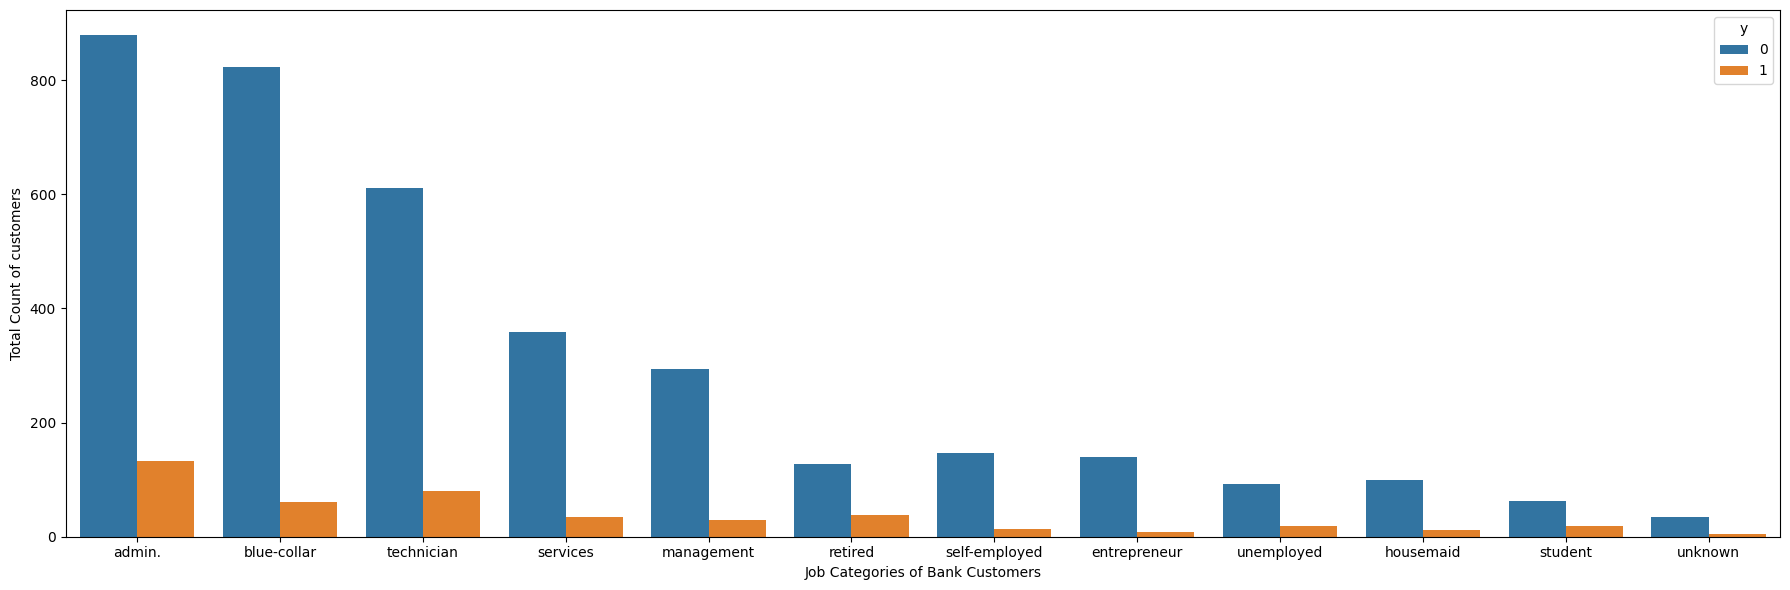

In [15]:
#customers who subscribed , job category wise
plt.figure(figsize=(18,6))
sns.countplot(x='job',hue='y', data=data_set, order=data_set['job'].value_counts().index)
plt.xlabel('Job Categories of Bank Customers', color='black')
plt.ylabel('Total Count of customers', color='black')
plt.tight_layout()
plt.show()

In [16]:
categorical = ['marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

for column in categorical:
    figure = px.pie(data_set, names=column, title=f"Customers Percentage for column {column}",
                 hole=0.3, color_discrete_sequence=px.colors.qualitative.Plotly)
    figure.update_traces(textinfo='percent+label')
    figure.show()

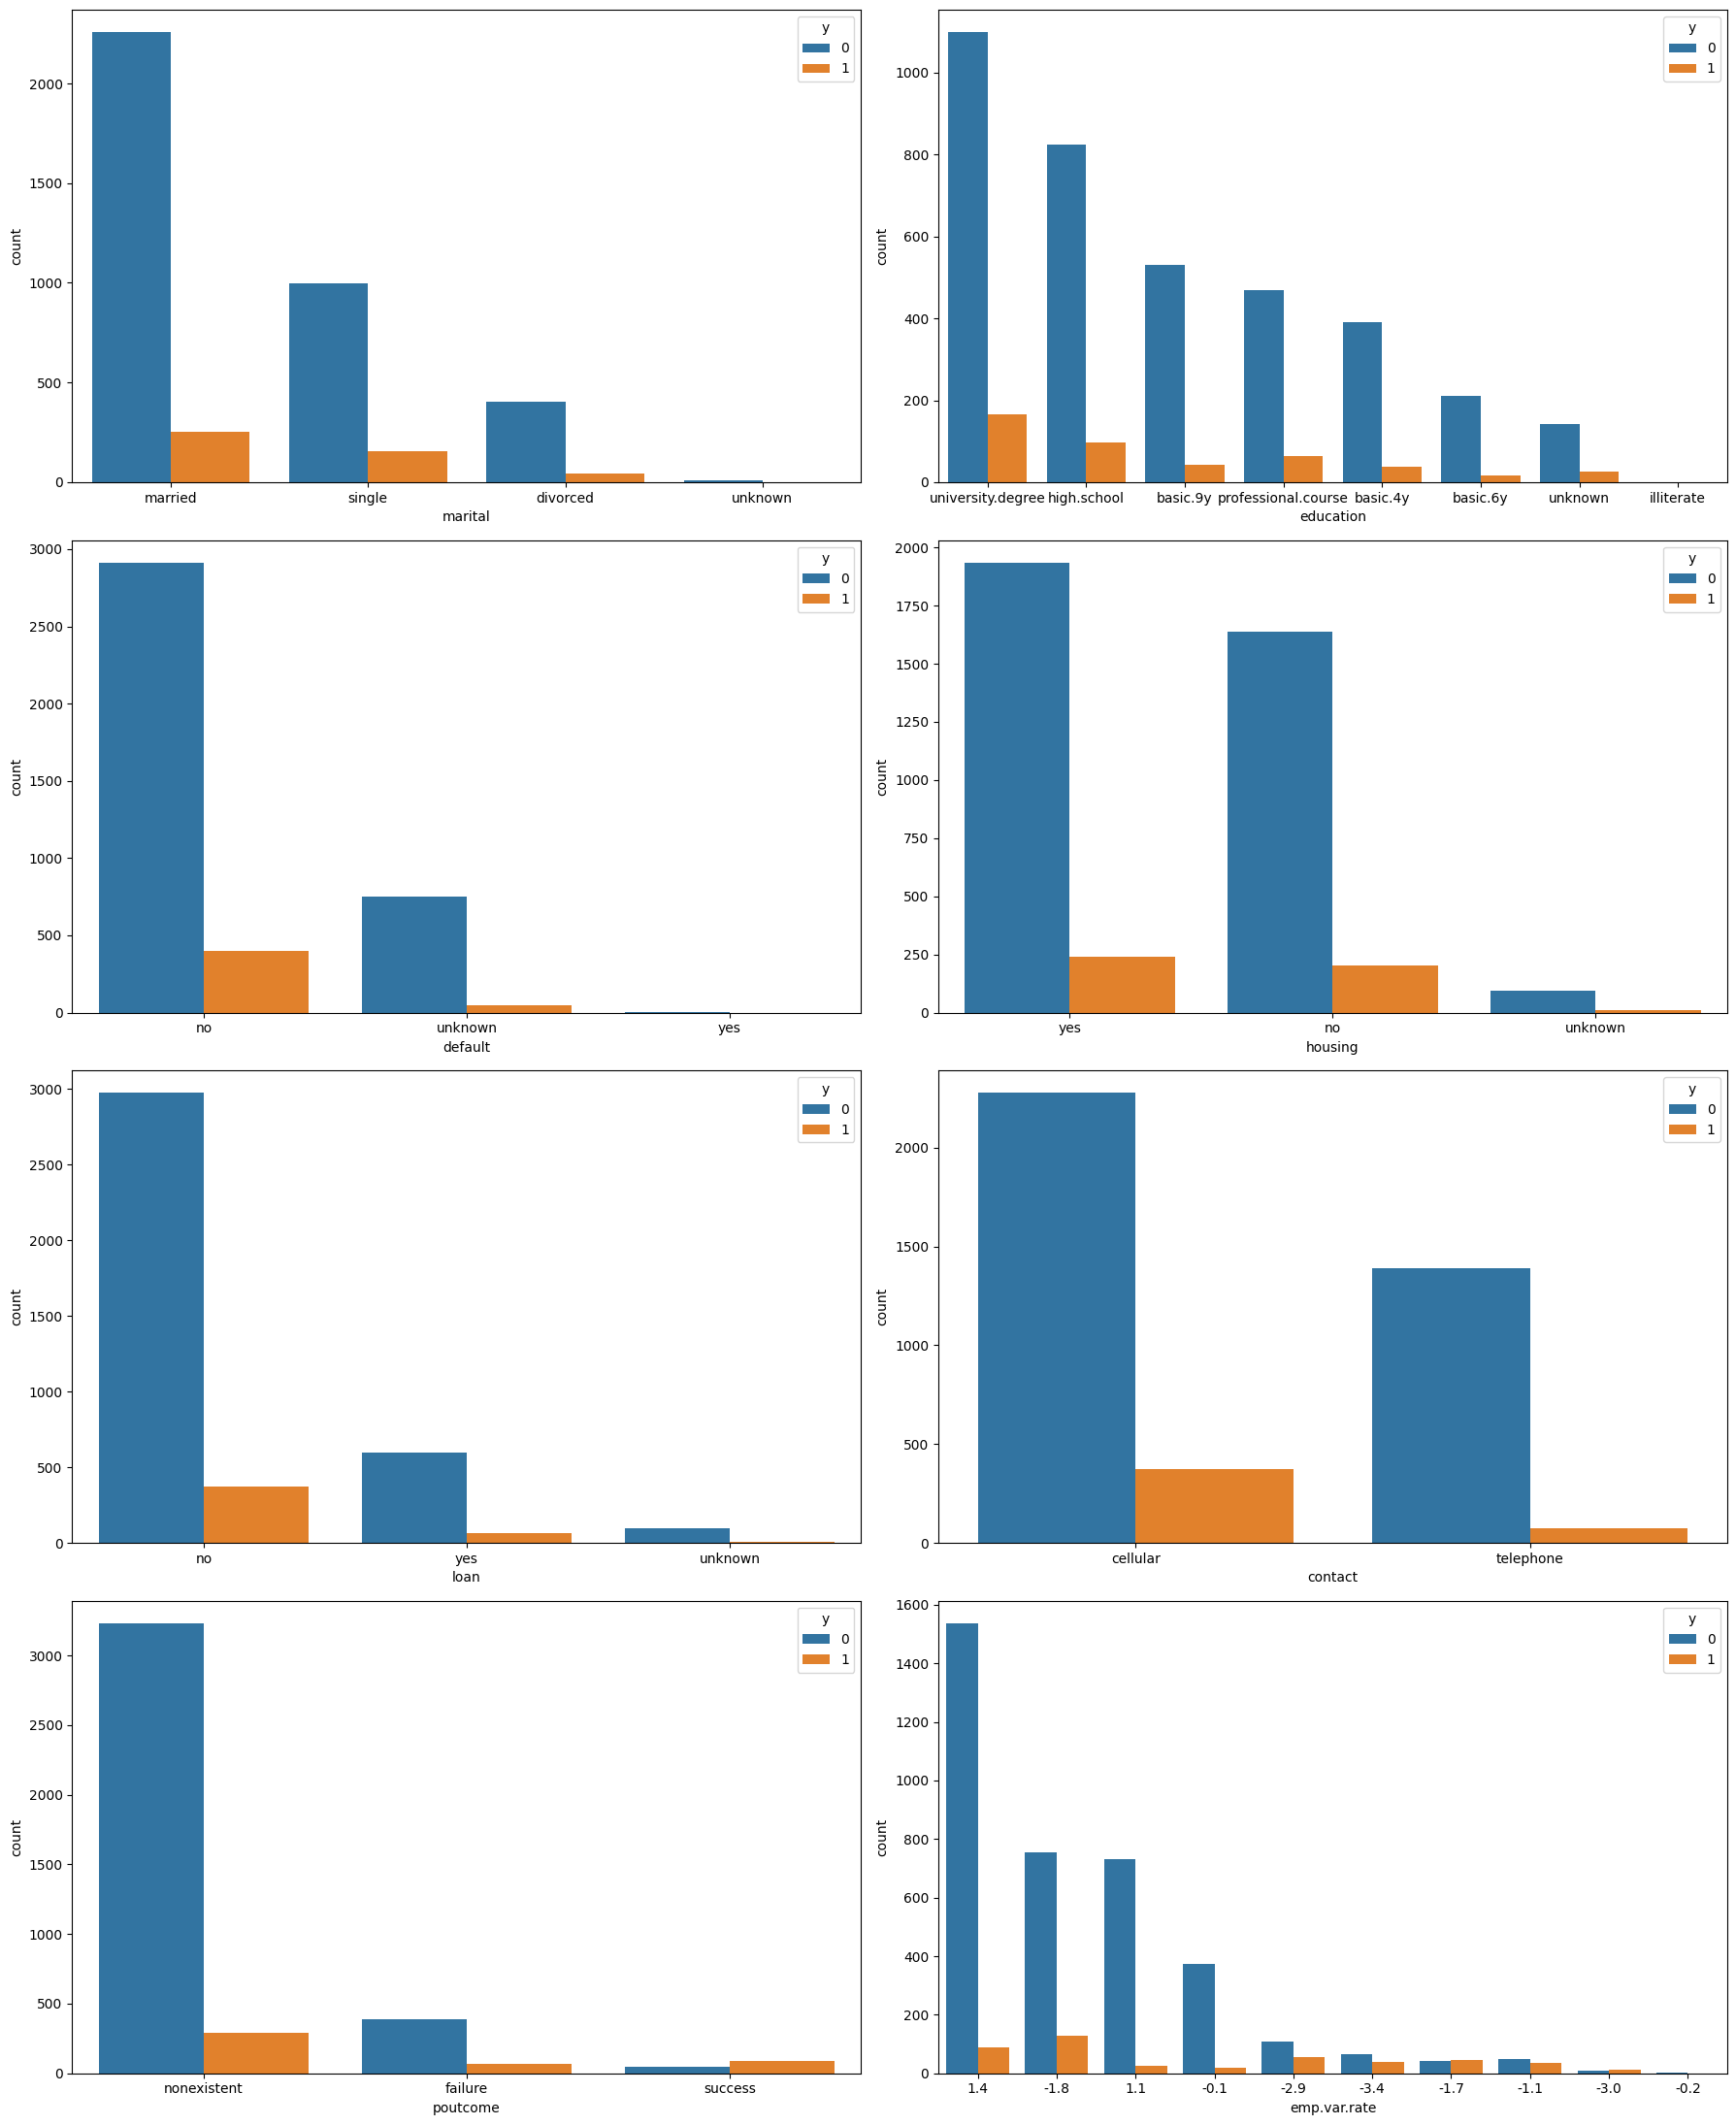

In [21]:
categorical = ['marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome',"emp.var.rate"]

plt.figure(figsize=(18,22))
n = 1
for column in categorical:
  ax = plt.subplot(4,2,n)
  sns.countplot(x = column, hue='y', data=data_set, order=data_set[column].value_counts().index)
  plt.xlabel(column)
  plt.tight_layout()
  n += 1
plt.show()

In [ ]:
#Create Bin features
month={"jan":1, "feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,
      "aug":8,"sep":9,"oct":10,"nov":11,"dec":12}

data_set["month_num"]=data_set["month"].map(month)

#Season features
data_set["winter"] = data_set["month_num"].isin([12,1,2]).astype(int)
data_set["spring"] = data_set["month_num"].isin([3,4,5]).astype(int)
data_set["summer"] = data_set["month_num"].isin([6,7,8]).astype(int)
data_set["autumn"] = data_set["month_num"].isin([9,10,11]).astype(int)

#day features
data_set["weekend"] = data_set["day_of_week"].isin(["sat","sun"]).astype(int)



In [ ]:
#Categorical features
categorical_features=["job","marital","education","default","housing",
                      "loan","contact","month","day_of_week","poutcome"]

#encoding
le=LabelEncoder()
for col in categorical_features:
  data_set[f'{col}_encoded']=le.fit_transform(data_set[col])


In [ ]:
#Binned features
data_set["age_bin"]=pd.qcut(data_set["age"],q=5, labels=["very_young","young","middle","senior","elderly"])
data_set["duration_bin"] = pd.qcut(data_set["duration"],q=5, labels=["very_short", "short","medium","long","very_long"])
data_set["campaign_bin"] = pd.cut(data_set["campaign"],bins=[0,2,4,6,8, np.inf],
                                  labels=["very_few","few","medium","many","very_many"])


In [ ]:
#Numeric columns
numeric_features=["age","duration","campaign","pdays","previous",
                  "emp.var.rate", "cons.price.idx","cons.conf.idx",
                  "euribor3m","nr.employed"]
original_data = data_set[numeric_features].copy()
for column in numeric_features:
  Q1=data_set[column].quantile(0.25)
  Q3=data_set[column].quantile(0.75)
  IQR=Q3-Q1
  lower_bound= Q1-3*IQR
  upper_bound= Q3+3*IQR
  data_set[column] = data_set[column].clip(lower=lower_bound, upper=upper_bound)

In [ ]:
#aggregate features
data_set["total_contacts"]=data_set["campaign"] + data_set["previous"]
data_set["contact_rate"]  =data_set["campaign"]/(data_set["previous"]+1)
data_set["economic_sentiment"]= data_set["emp.var.rate"] *data_set["cons.conf.idx"]
data_set["market_conditions"]=data_set["cons.price.idx"]*data_set["euribor3m"]

In [ ]:
#interaction features
data_set["age_by_job"] = data_set["age"] * data_set["job_encoded"]
data_set["age_by_education"] = data_set["age"] * data_set["education_encoded"]
data_set["duration_by_contact"] = data_set["duration"] * data_set["contact_encoded"]
data_set["duration_by_month"] = data_set["duration"] * data_set["month_num"]
data_set["campaign_by_previous"] = data_set["campaign"] * data_set["previous"]
data_set["campaign_by_outcome"] = data_set["campaign"] * data_set["poutcome_encoded"]
data_set["emp_rate_by_euribor"] = data_set["emp.var.rate"] * data_set["euribor3m"]
data_set["price_by_confidence"] = data_set["cons.price.idx"] * data_set["cons.conf.idx"]

In [ ]:
#Encode bin columns
for col in ["age_bin","duration_bin","campaign_bin"]:
  data_set[f'{col}_encoded']= le.fit_transform(data_set[col])

features_to_drop= categorical_features + ["age_bin","duration_bin","campaign_bin"]
data_set=data_set.drop(features_to_drop,axis=1)

In [ ]:
#features and target
X= data_set.drop("y",axis=1)
y= data_set["y"]

#Remove correlated features
corr_matrix= X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
to_drop=[column for column in upper.columns if any(upper[column]>0.85)]
X=X.drop(to_drop, axis=1)


In [ ]:
#feature selection using random forest
sel_model = RandomForestClassifier(n_estimators=200, random_state=42)
sel_model.fit(X,y)
selector= SelectFromModel(sel_model, prefit=True, threshold="median")
feature_idx=selector.get_support()
feature_names=X.columns[feature_idx]
X= X[feature_names]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

scaler=RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [ ]:
#Training the model
param_grid={
    "n_estimators":[300],
    "max_depth" :[10,15,20,25,None],
    "min_samples_split": [2,5,10],
    "min_samples_leaf":[1,2,4],
    "max_features":["sqrt","log2"],
    "class_weight":["balanced","balanced_subsample"],
    "criterion" : ["gini","entropy"],
    "bootstrap": [True],
    "max_samples":[0.7,0.8,0.9]
}

base_rf= RandomForestClassifier(random_state=42, n_jobs=-1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_random=RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_grid,
    n_iter=100,
    cv=cv,
    scoring="f1",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_random.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 15, 20, 25, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'max_samples': [0.7, 0.8, 0.9],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [300]},
                   random_state=42, scoring='f1', verbose=1)

In [ ]:
# Make predictions and evaluate
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test_scaled)
y_pred_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

# Print results
print("\nBest Parameters:")
print(rf_random.best_params_)

print("\nFeature Importances:")
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)
print(importances.head(10))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


Best Parameters:
{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_samples': 0.8, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': True}

Feature Importances:
                 feature  importance
1               duration    0.291922
3           emp.var.rate    0.118869
14  duration_bin_encoded    0.100467
5          cons.conf.idx    0.071730
12   duration_by_contact    0.062863
4         cons.price.idx    0.054641
0                    age    0.054418
11      poutcome_encoded    0.043881
7            job_encoded    0.034478
6              month_num    0.033158

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       734
           1       0.60      0.70      0.65        90

    accuracy                           0.92       824
   macro avg       0.78      0.82      0.80       824
weighted avg       0.92      0.92      0.92       824



In [ ]:
train_accuracy = best_rf.score(X_train_scaled, y_train)
print(f"Training Accuracy: {train_accuracy:.5f}")

# Check testing accuracy
test_accuracy = best_rf.score(X_test_scaled, y_test)
print(f"Testing Accuracy: {test_accuracy:.5f}")

Training Accuracy: 0.95205
Testing Accuracy: 0.91626


In [ ]:
def weighted_binary_crossentropy(y_true, y_pred, pos_weight=2.0):
    y_true = tf.cast(y_true, tf.float32)
    weights = tf.where(tf.equal(y_true, 1), pos_weight * tf.ones_like(y_true), tf.ones_like(y_true))
    binary_crossentropy = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    weighted_loss = weights * binary_crossentropy
    return tf.reduce_mean(weighted_loss)

def build_model(input_dim, pos_weight=2.0):
    inputs = Input(shape=(input_dim,))

    x = Dense(128,
              kernel_initializer='glorot_normal',
              kernel_regularizer=l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = Dropout(0.3)(x)

    x = Dense(64,
              kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = Dropout(0.2)(x)

    outputs = Dense(1,
                   activation='sigmoid',
                   kernel_initializer='glorot_normal',
                   bias_initializer=tf.keras.initializers.Constant(0.0))(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, pos_weight),
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            # Modified F1Score configuration
            tf.keras.metrics.F1Score(
                threshold=0.5,
                name='f1',
                dtype=tf.float32
            )
        ]
    )

    return model

def preprocess_data(X_train, X_test, y_train, sampling_ratio=0.3):
    # Power transform features
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    X_train_transformed = pt.fit_transform(X_train)
    X_test_transformed = pt.transform(X_test)

    # Reshape y_train to 2D array
    y_train = np.asarray(y_train).reshape(-1, 1)

    # Controlled resampling
    smt = SMOTETomek(random_state=42, sampling_strategy=sampling_ratio)
    X_train_resampled, y_train_resampled = smt.fit_resample(X_train_transformed, y_train)

    # Ensure y_train_resampled is 2D
    y_train_resampled = y_train_resampled.reshape(-1, 1)

    # Convert to float32
    y_train_resampled = y_train_resampled.astype(np.float32)

    return X_train_resampled, X_test_transformed, y_train_resampled

def find_optimal_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0.2, 0.8, 30)
    best_score = 0
    best_threshold = 0.5

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        balanced_acc = (sensitivity + specificity) / 2

        f1 = precision_score(y_true, y_pred) * recall_score(y_true, y_pred)
        if f1 > 0:
            f1 = 2 * f1 / (precision_score(y_true, y_pred) + recall_score(y_true, y_pred))

        score = (0.7 * f1) + (0.3 * balanced_acc)

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_threshold

# Prepare data
X_train_resampled, X_test_transformed, y_train_resampled = preprocess_data(
    X_train_scaled,
    X_test_scaled,
    y_train
)

# Calculate positive class weight based on resampled data distribution
pos_weight = np.sum(y_train_resampled == 0) / np.sum(y_train_resampled == 1)

# Build model
model = build_model(X_train_scaled.shape[1], pos_weight=pos_weight)

# Training callbacks
early_stopping = EarlyStopping(
    monitor='val_f1',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_f1',
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train model
history = model.fit(
    X_train_resampled,
    y_train_resampled,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Final evaluation
y_pred_proba = model.predict(X_test_transformed)
best_threshold = find_optimal_threshold(y_test, y_pred_proba)
y_pred = (y_pred_proba >= best_threshold).astype(int)

print(f"\nOptimal threshold: {best_threshold:.3f}")
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.8585 - auc: 0.5579 - f1: 0.1528 - loss: 1.5123 - precision: 0.1970 - recall: 0.1290 - val_accuracy: 0.5340 - val_auc: 0.9396 - val_f1: 0.5346 - val_loss: 2.6899 - val_precision: 0.9805 - val_recall: 0.3675 - learning_rate: 0.0010
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9027 - auc: 0.8879 - f1: 0.3629 - loss: 0.9589 - precision: 0.5528 - recall: 0.2715 - val_accuracy: 0.5792 - val_auc: 0.9483 - val_f1: 0.5990 - val_loss: 2.3698 - val_precision: 0.9793 - val_recall: 0.4314 - learning_rate: 0.0010
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9077 - auc: 0.9054 - f1: 0.3819 - loss: 0.7248 - precision: 0.5289 - recall: 0.2992 - val_accuracy: 0.6631 - val_auc: 0.9511 - val_f1: 0.7055 - val_loss: 2.1132 - val_precision: 0.9712 - val_recall: 0.5539 - learning_rate: 0.0010
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9083 - auc: 0.9154 - f1: 0.5021 - loss: 0.5988 -